In [1]:
import cv2
import numpy as np
from IPython.display import display, Javascript, HTML
from google.colab.patches import cv2_imshow
from google.colab import output
import PIL
import io
import base64


# Open Video from your Webcam

In [2]:
# Imports
import cv2
import numpy as np
import IPython.display as display
from google.colab.patches import cv2_imshow
from google.colab import output
import PIL
import io
import base64

# Globals
video_frames = []
recording = True

# Function to receive frames
def capture_frame(image_data):
    global video_frames, recording
    image_bytes = base64.b64decode(image_data.split(',')[1])
    image = PIL.Image.open(io.BytesIO(image_bytes))
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if recording:
        video_frames.append(image)

# Function to save video
def save_video():
    global video_frames, recording
    if video_frames:
        height, width, _ = video_frames[0].shape
        fps = 10
        out = cv2.VideoWriter('recorded_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
        for frame in video_frames:
            out.write(frame)
        out.release()
        print("✅ Video saved as 'recorded_video.mp4'")
    else:
        print("⚠️ No frames recorded.")
    video_frames.clear()

# Register callbacks
output.register_callback('notebook.captureFrame', capture_frame)
output.register_callback('notebook.saveVideo', save_video)

# JavaScript to open cam and auto-record
js = """
let videoStream;
let videoElement;
let recording = false;

async function openAndRecord() {
  videoElement = document.createElement('video');
  videoStream = await navigator.mediaDevices.getUserMedia({ video: true });
  videoElement.srcObject = videoStream;
  videoElement.autoplay = true;
  videoElement.style.width = '50%';
  document.body.appendChild(videoElement);

  await new Promise((resolve) => (videoElement.onloadedmetadata = resolve));
  videoElement.play();
  recording = true;
  recordLoop();
}

async function recordLoop() {
  while (recording) {
    const canvas = document.createElement('canvas');
    canvas.width = videoElement.videoWidth;
    canvas.height = videoElement.videoHeight;
    canvas.getContext('2d').drawImage(videoElement, 0, 0, canvas.width, canvas.height);
    const imageData = canvas.toDataURL('image/jpeg');
    google.colab.kernel.invokeFunction('notebook.captureFrame', [imageData], {});
    await new Promise(resolve => setTimeout(resolve, 100)); // Adjust interval
  }
}

// Stop & Save
function stopRecording() {
  recording = false;
  google.colab.kernel.invokeFunction('notebook.saveVideo', [], {});
}

// Close cam
function closeCamera() {
  if (videoStream) {
    videoStream.getTracks().forEach(track => track.stop());
    videoElement.remove();
    videoStream = null;
  }
}

// Buttons
if (!document.getElementById('stopRecordingButton')) {
  const stopBtn = document.createElement('button');
  stopBtn.innerText = 'Stop Recording';
  stopBtn.id = 'stopRecordingButton';
  stopBtn.onclick = stopRecording;
  document.body.appendChild(stopBtn);
}

if (!document.getElementById('closeCameraButton')) {
  const closeBtn = document.createElement('button');
  closeBtn.innerText = 'Close Camera';
  closeBtn.id = 'closeCameraButton';
  closeBtn.onclick = closeCamera;
  document.body.appendChild(closeBtn);
}

openAndRecord();
"""

# Display JS
display.display(display.Javascript(js))


<IPython.core.display.Javascript object>

# Use Your Webcam Feed to Create a Live Sketch of Yourself

<IPython.core.display.Javascript object>

Camera started with sketch effect. Processing frames...


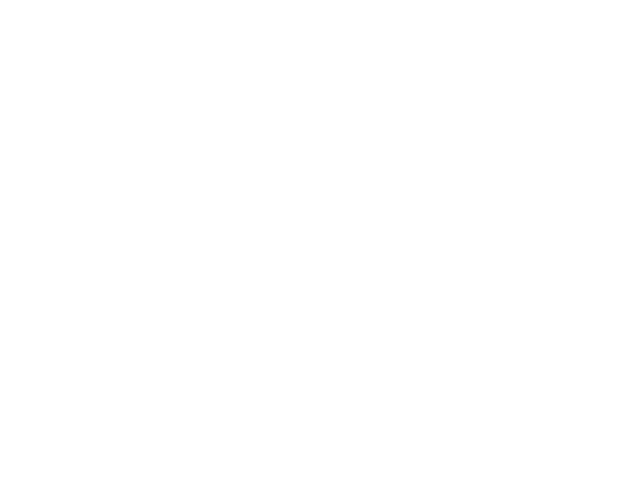

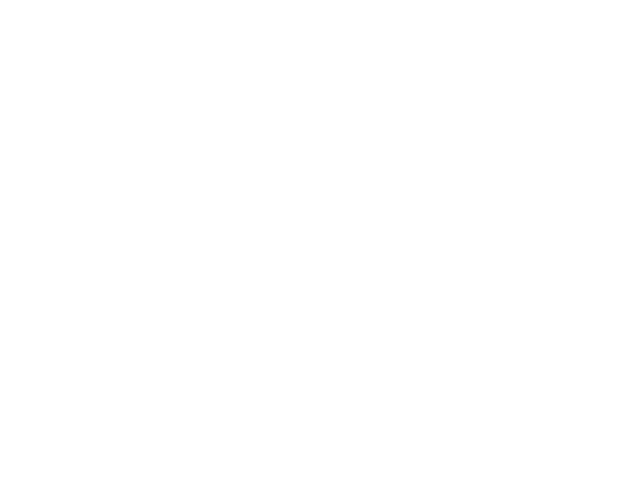

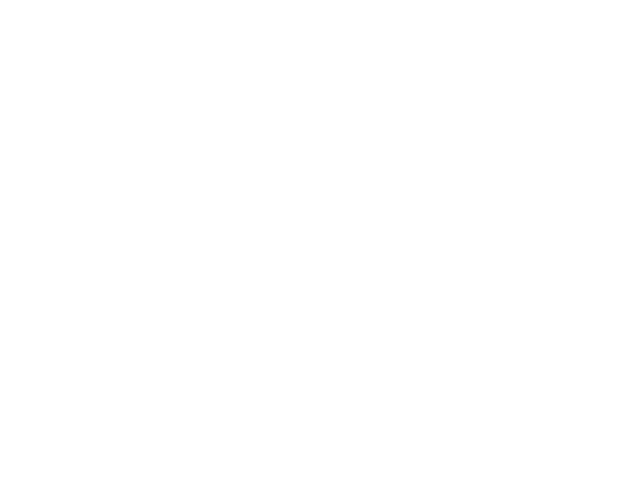

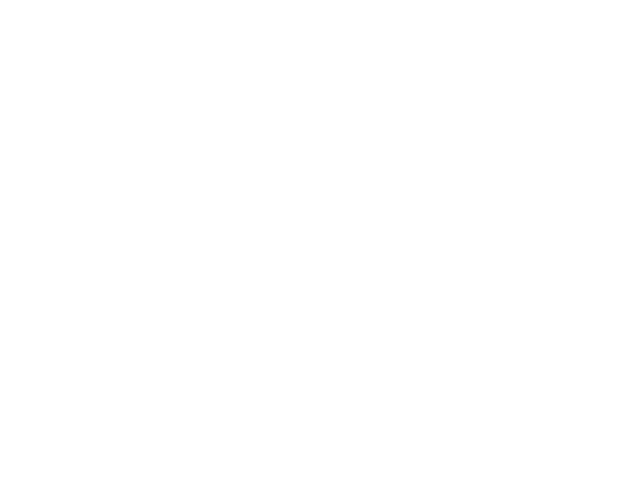

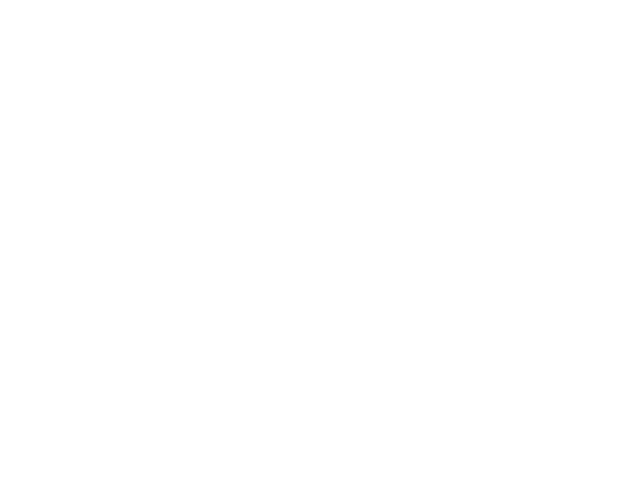

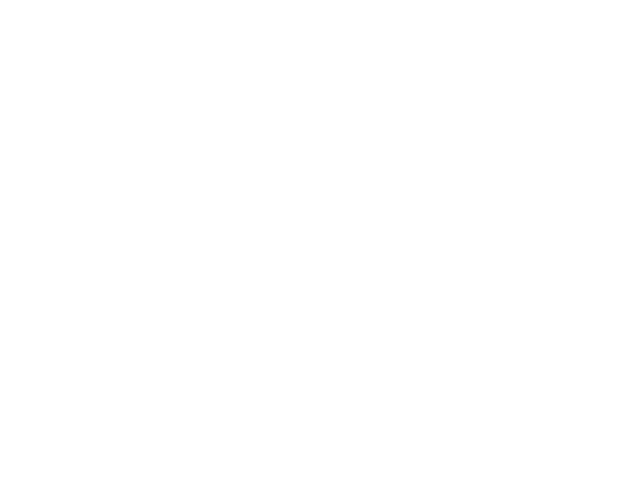

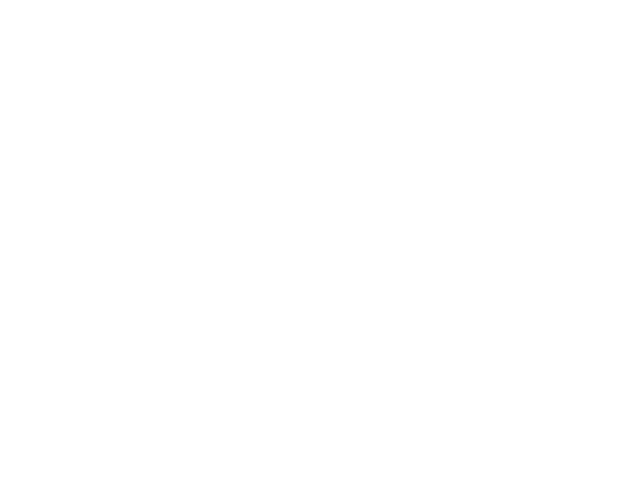

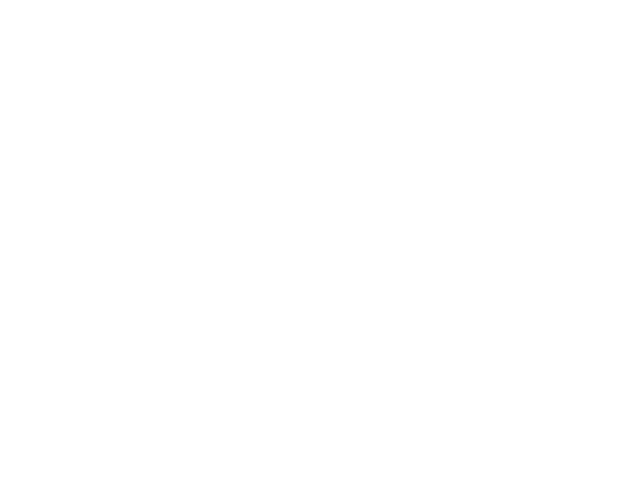

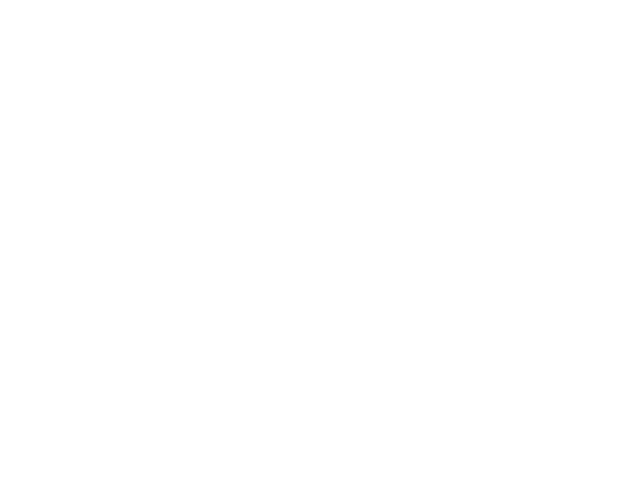

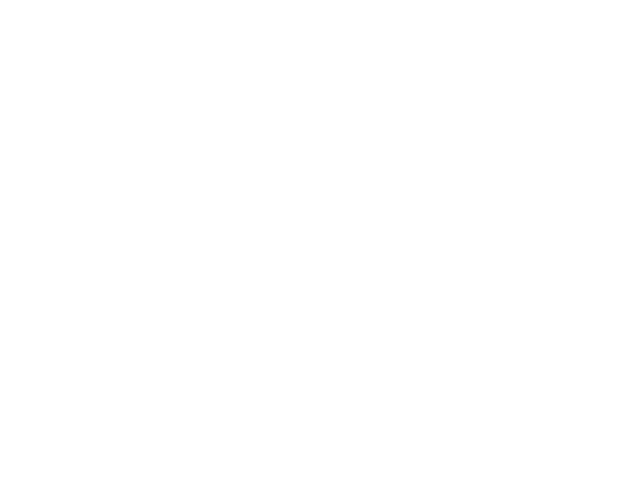

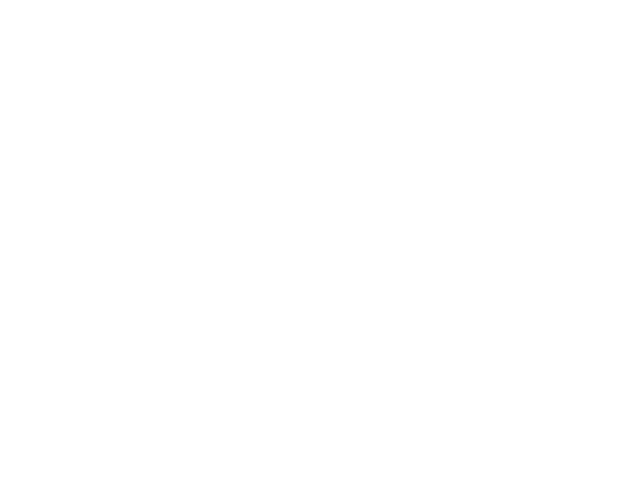

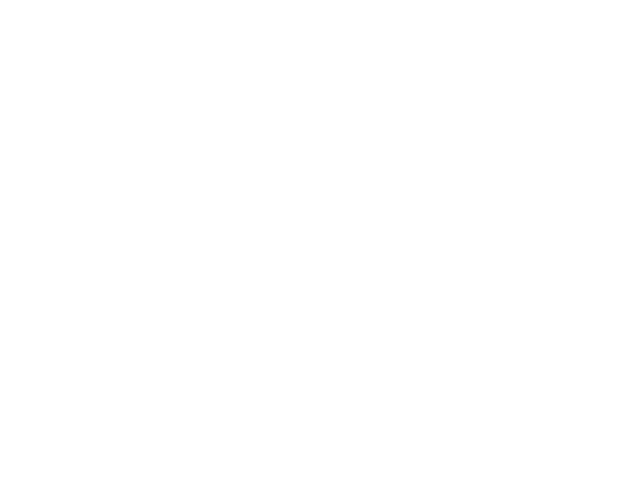

In [3]:
import cv2
import numpy as np
import PIL
import io
import base64
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, HTML
from google.colab import output
import time

# Our sketch generating function
def sketch(image):
    # Convert image to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Clean up image using Guassian Blur
    img_gray_blur = cv2.GaussianBlur(img_gray, (5,5), 0)

    # Extract edges
    canny_edges = cv2.Canny(img_gray_blur, 10, 70)

    # Do an invert binarize the image
    ret, mask = cv2.threshold(canny_edges, 70, 255, cv2.THRESH_BINARY_INV)
    return mask

# Process frame and display sketch
def process_frame(frame_data):
    # Decode base64 image
    image_bytes = base64.b64decode(frame_data.split(',')[1])
    image = PIL.Image.open(io.BytesIO(image_bytes))
    image_np = np.array(image)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Apply sketch effect
    sketch_result = sketch(image_bgr)

    # Display the sketch
    cv2_imshow(sketch_result)

    return True

# JavaScript to access camera and send frames to Python
js_code = """
async function processCamera() {
  const video = document.createElement('video');
  const container = document.createElement('div');
  container.style.position = 'relative';
  document.body.appendChild(container);

  // Create stop button
  const stopBtn = document.createElement('button');
  stopBtn.textContent = 'Stop Camera';
  stopBtn.style = 'position: absolute; top: 5px; right: 5px; z-index: 100; padding: 5px 10px; background: red; color: white; border: none; border-radius: 3px;';
  container.appendChild(stopBtn);

  try {
    // Access webcam
    const stream = await navigator.mediaDevices.getUserMedia({video: true});
    video.srcObject = stream;
    video.style.display = 'none';
    container.appendChild(video);

    await new Promise(resolve => video.onloadedmetadata = resolve);
    video.play();

    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const ctx = canvas.getContext('2d');

    // Keep sending frames until stopped
    let keepRunning = true;

    stopBtn.onclick = () => {
      keepRunning = false;
      stream.getTracks().forEach(track => track.stop());
      container.remove();
    };

    while (keepRunning) {
      // Draw video to canvas
      ctx.drawImage(video, 0, 0);

      // Get frame as data URL
      const imageData = canvas.toDataURL('image/jpeg');

      // Send to Python for processing
      await google.colab.kernel.invokeFunction('process_frame', [imageData], {});

      // Small delay to not overwhelm the system
      await new Promise(resolve => setTimeout(resolve, 100));
    }
  } catch (err) {
    console.error('Camera error:', err);
  }
}

// Start processing
processCamera();
"""

# Register our function
output.register_callback('process_frame', process_frame)

# Clear any previous output
from IPython.display import clear_output
clear_output()

# Start the camera with JavaScript
display(Javascript(js_code))
print("Camera started with sketch effect. Processing frames...")